In [1]:
import jax
import jax.numpy as jnp
from jax import random
import pandas as pd
from tqdm import tqdm
from ott.geometry import costs, pointcloud
from ott.solvers import linear
from ott.solvers.linear.univariate import UnivariateSolver
from ott.problems.linear import linear_problem
import matplotlib.pyplot as plt
from ot.datasets import make_1D_gauss as gauss
import sys

sys.path.append('C:/Users/eriki/OneDrive/Documents/all_folder/Thesis/Thesis/utils')
from utils.utils import *
from utils.Visualizations import *

### Function definitions

In [ ]:
class AbsoluteDifferenceCost(costs.TICost):
    def h(self, x: jnp.ndarray) -> jnp.ndarray:
        return jnp.abs(x)

class SquareDifferenceTICost(costs.TICost):
    def h(self, x: jnp.ndarray) -> jnp.ndarray:
        # In a translation-invariant cost, h(x) computes the cost based on the difference x
        return x ** 2

In [3]:
def solve_ott(x, y, cost_fn=AbsoluteDifferenceCost(), solver=UnivariateSolver()):
    geom = pointcloud.PointCloud(x[:, jnp.newaxis], y[:, jnp.newaxis], cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)

    solve_fn = jax.jit(linear.solve)

    result = solve_fn(geom)
    return result.mean_transport_matrix

### Example distribution

In [4]:
# Parameters for the Gaussian distributions
res = 100
mean1, std1 = 0.65, 0.1  # Parameters for the first Gaussian
mean2, std2 = 0.35, 0.1  # Parameters for the second Gaussian
noise_std = 1e-2
num_samples = 1000  # Number of samples from each distribution

# Generate sample data
x = jnp.array(gauss(res, res * mean1, res * std1))
y = jnp.array(gauss(res, res * mean2, res * std2))

noise_x = noise_std * jax.random.normal(jax.random.PRNGKey(2), x.shape)
noise_y = noise_std * jax.random.normal(jax.random.PRNGKey(3), y.shape)
noisy_x = x + noise_x
noisy_y = y + noise_y

CDF_x = jnp.cumsum(x)
CDF_y = jnp.cumsum(y)

# Euclidean cost function
cost_fn = AbsoluteDifferenceCost()

# Create a PointCloud geometry
geom = pointcloud.PointCloud(CDF_x[:, jnp.newaxis], CDF_y[:, jnp.newaxis], cost_fn=None)


solve_fn = jax.jit(linear.solve)
result = solve_fn(geom)
# Create a LinearProblem
prob = linear_problem.LinearProblem(geom)

# Instantiate and use the UnivariateSolver
solver = UnivariateSolver()
result = solver(prob)

In [5]:
result.ot_costs.sum()

Array(0.18887651, dtype=float32)

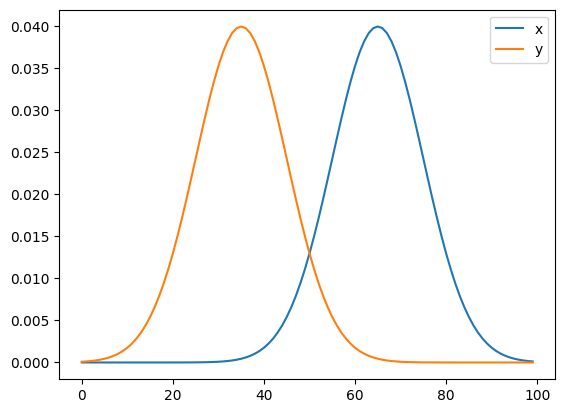

In [15]:
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.legend()
plt.show()

TypeError: Cannot interpret value of type <class '__main__.AbsoluteDifferenceCost'> as an abstract array; it does not have a dtype attribute

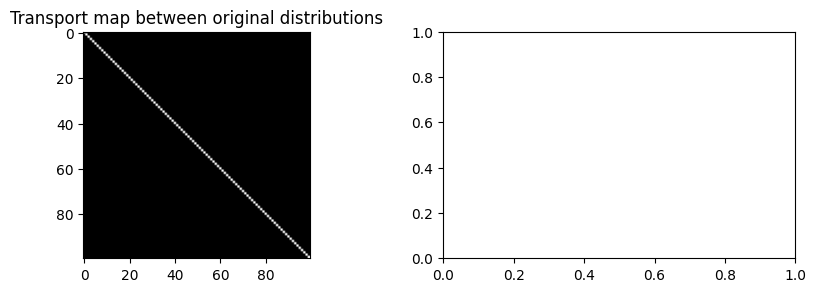

In [16]:
plt.figure(figsize=(10,10))

# Original distributions
plt.subplot(3,2,1)
plt.imshow(result.transport_matrices[0], cmap='gray')
plt.title('Transport map between original distributions')

# CDF - original
plt.subplot(3,2,2)
CDF_x = jnp.cumsum(x)
CDF_y = jnp.cumsum(y)
plt.imshow(solve_ott(CDF_x, CDF_y), cmap='gray')
plt.title('Original - CDF')


# Noised distributions
plt.subplot(3,2,3)
plt.imshow(solve_ott(noisy_x_jnp, noisy_y_jnp), cmap='gray')
plt.title('Transport map between noised distributions')

# CDF - Noised
plt.subplot(3,2,4)
CDF_x = jnp.cumsum(noisy_x)
CDF_y = jnp.cumsum(noisy_y)
plt.imshow(solve_ott(CDF_x, CDF_y), cmap='gray')
plt.title('Noised - CDF')

# Posterior distributions
x_pos, x_neg = jnp.where(noisy_x>=0, noisy_x, 0), jnp.where(noisy_x<0, noisy_x, 0)
y_pos, y_neg = jnp.where(noisy_y>=0, noisy_y, 0), jnp.where(noisy_y<0, noisy_y, 0)
x_post = x_pos + y_neg
y_post = y_pos + x_neg
plt.subplot(3,2,5)
plt.imshow(solve_ott(x_post, y_post), cmap='gray')
plt.title('Transport map between posterior distributions')

# CDF - Posterior
plt.subplot(3,2,6)
CDF_x = jnp.cumsum(x_post)
CDF_y = jnp.cumsum(y_post)
plt.imshow(solve_ott(CDF_x, CDF_y), cmap='gray')
plt.title('Posterior - CDF')

In [ ]:
type(noisy_x)

#### Sanity checks

In [7]:
np.count_nonzero(result.transport_matrices[0])

100

In [8]:
row_sums = np.sum(result.transport_matrices[0], axis=1)
col_sums = np.sum(result.transport_matrices[0], axis=0)

print(row_sums)
print(col_sums)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


### Averaging many samples

In [9]:
def compute_cdf(arr):
    # Normalize the array to sum to 1 and compute the cumulative sum to get the CDF
    return jnp.cumsum(arr) / jnp.sum(arr)

class PWassersteinCost(costs.TICost):
    def __init__(self, p_value=1):
        self.p_value = p_value

    def pairwise(self, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
        # Compute the p-th power of absolute differences
        return jnp.abs(x - y) ** self.p_value
        
def wasserstein_distance(p, q, wasserstein_p=1):
    # Compute the CDFs for p and q
    cdf_p = compute_cdf(p)
    cdf_q = compute_cdf(q)

    # Function to compute the Wasserstein distance
    if wasserstein_p == 1:
        cost_fn = AbsoluteDifferenceCost()  # Use the appropriate cost function here
    elif wasserstein_p == 2:
        cost_fn = SquareDifferenceTICost()
    else:
        raise ValueError('Invalid distance metric, only supporting W1 and W2 at the moment')
    geom = pointcloud.PointCloud(cdf_p[:, jnp.newaxis], cdf_q[:, jnp.newaxis], cost_fn=cost_fn)
    prob = linear_problem.LinearProblem(geom)
    solver = UnivariateSolver()
    result = solver(prob)

    # Return the Wasserstein distance raised to the power of 1/wasserstein_p
    if wasserstein_p == 1:
        return result.ot_costs.sum()
    elif wasserstein_p == 2:
        return jnp.sqrt(result.ot_costs.sum())

In [10]:
def run_experiment_and_append(df, res, SNR, num_samples=100, wasserstein_p=1,
                                     first_center=0.35, first_std=0.1,
                                     second_center=0.65, second_std=0.1) -> pd.DataFrame:
    
    # Generate Gaussian distributions
    p = gauss(res, m=res * first_center, s=res * first_std)
    q = gauss(res, m=res * second_center, s=res * second_std)
    # Calculate signal power and determine noise level
    signal_power = (p ** 2).sum()
    noise_level = noise_from_SNR(SNR, signal_power=signal_power, res=res)

     # Initialize accumulators for the results
    total_original_distance = 0
    total_noised_distance = 0
    total_post_process_distance = 0

    for _ in range(num_samples):

        # Compute original and noised Wasserstein distances
        original_distance = wasserstein_distance(p, q, wasserstein_p)

        # Add noise to the distributions
        key1, key2 = random.split(random.PRNGKey(0), 2)
        noisy_p = p + noise_level * random.normal(key1, p.shape)
        noisy_q = q + noise_level * random.normal(key2, q.shape)
        noised_distance = wasserstein_distance(noisy_p, noisy_q, wasserstein_p)

        # Post-processing: Swap positive and negative parts
        p_pos, p_neg = noisy_p[noisy_p >= 0], noisy_p[noisy_p < 0]
        q_pos, q_neg = noisy_q[noisy_q >= 0], noisy_q[noisy_q < 0]
        p_post = jnp.concatenate((p_pos, q_neg))
        q_post = jnp.concatenate((q_pos, p_neg))

        # Compute Wasserstein distance for post-processed distributions
        post_process_distance = wasserstein_distance(p_post, q_post, wasserstein_p)

        # Accumulate results
        total_original_distance += original_distance
        total_noised_distance += noised_distance
        total_post_process_distance += post_process_distance

    # Calculate averages
    avg_original_distance = total_original_distance / num_samples
    avg_noised_distance = total_noised_distance / num_samples
    avg_post_process_distance = total_post_process_distance / num_samples
    ratio = avg_original_distance / avg_noised_distance

    
    # Prepare the data to be appended
    new_row = {
        'Res': res,
        'SNR': SNR,
        'Signal_Power': signal_power,
        'Noise_Level': noise_level,
        'Wasserstein_p': wasserstein_p,
        'Distance_Original': original_distance,
        'Distance_Noised': noised_distance,
        'Distance_Post': post_process_distance,
        'Ratio': original_distance / noised_distance 
    }

    # Append new data to DataFrame
    return df._append(new_row, ignore_index=True)


In [12]:
df = pd.DataFrame()
res_values = [int(x) for x in jnp.linspace(start=100, stop=400, num=4)]
SNR_values = jnp.logspace(start=-2, stop=1, num=31)
wasserstein_ps = [1,2]

for res in tqdm(res_values):
    for SNR in SNR_values:
        for wasserstein_p in wasserstein_ps:
            df = run_experiment_and_append(df=df, res=res, SNR=SNR, num_samples=200, wasserstein_p=wasserstein_p)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [55:46<00:00, 836.62s/it]


In [13]:
df.head()

,Res,SNR,Signal_Power,Noise_Level,Wasserstein_p,Distance_Original,Distance_Noised,Distance_Post,Ratio
0,100,0.01,0.02822,0.167989,1,0.29982382,0.26714027,43.428772,1.122346
1,100,0.01,0.02822,0.167989,2,0.4345993,0.31171218,3.033755,1.3942327
2,100,0.012589254,0.02822,0.149720,1,0.29982382,0.26264015,41.279266,1.1415765
3,100,0.012589254,0.02822,0.149720,2,0.4345993,0.29852998,2.837325,1.4557979
4,100,0.015848933,0.02822,0.133438,1,0.29982382,0.25872642,39.47908,1.1588451


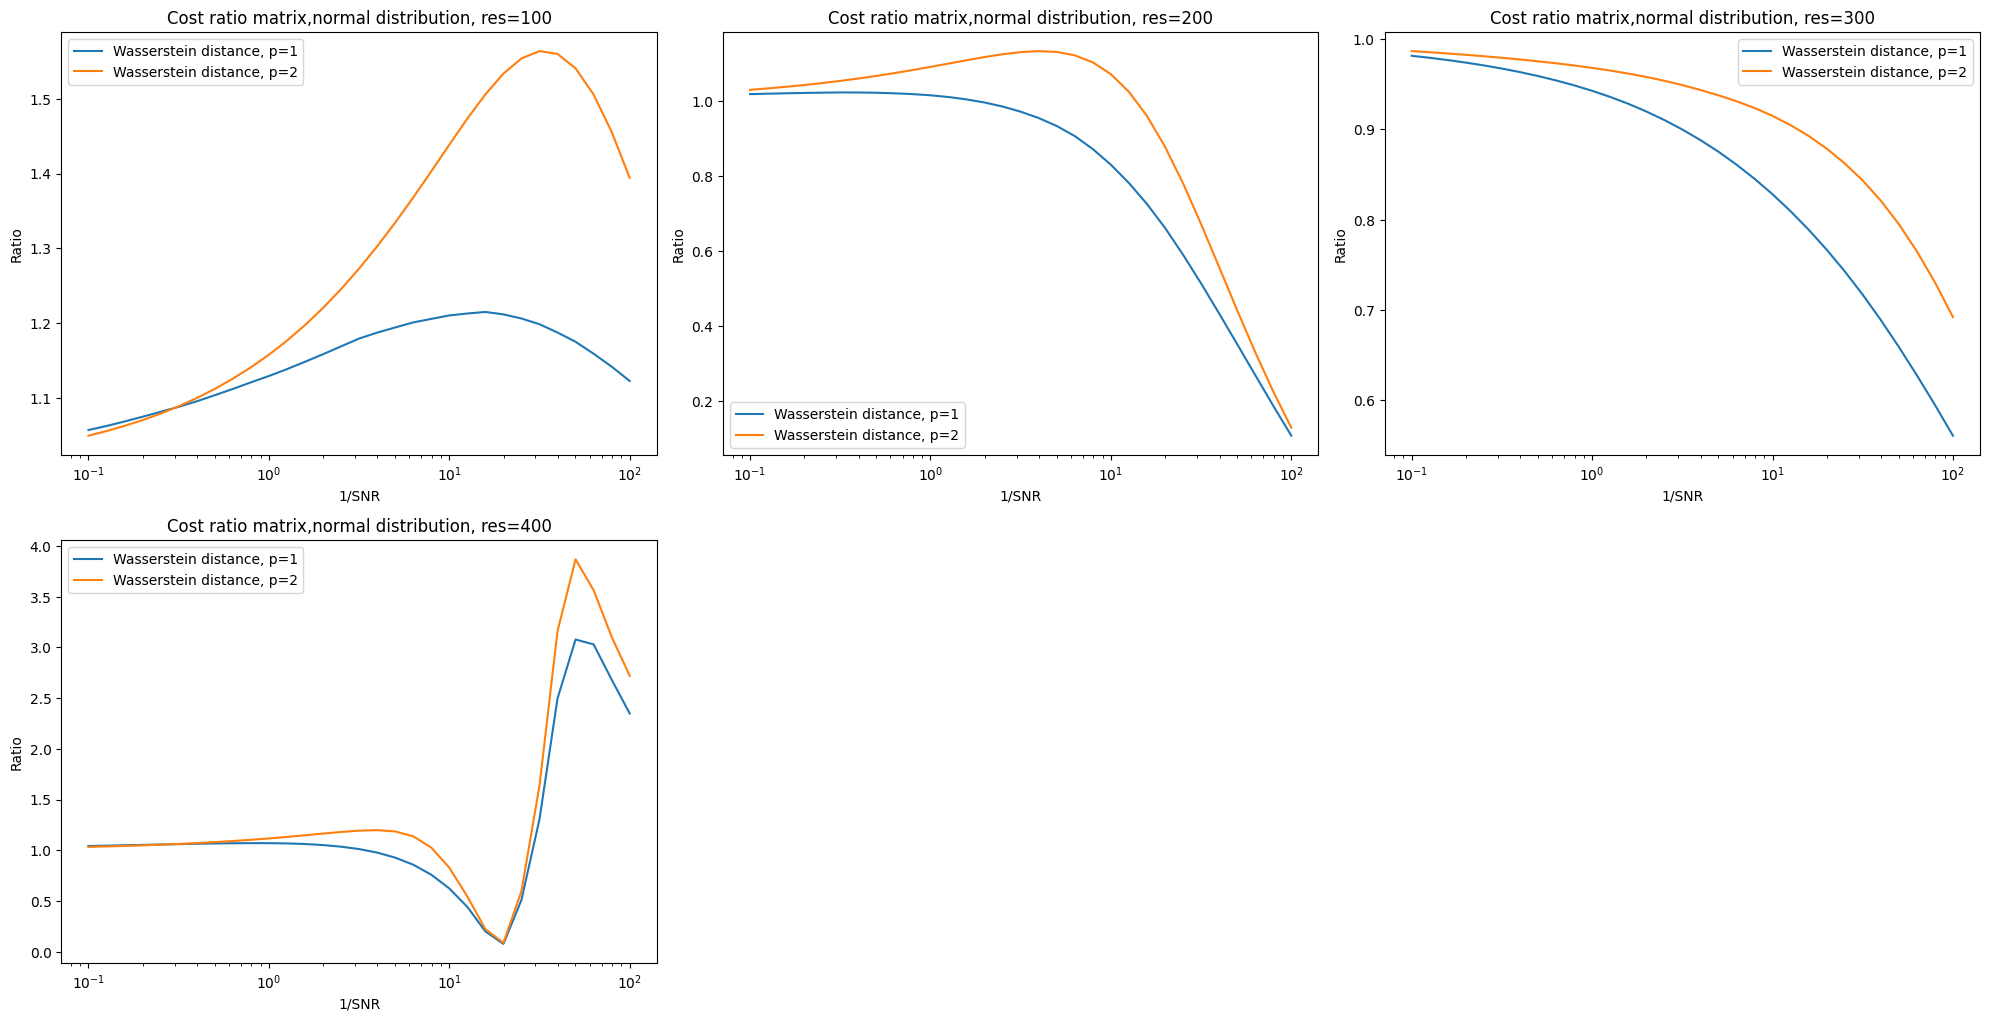

In [14]:
plt.figure(figsize=(20,20))

for i, res_option in enumerate(res_values):
    # Filter the dataframe based on current 'res' and 'scale' options
    filtered_df = df[(df['Res'] == res_option)]
    filtered_df1 = filtered_df[filtered_df['Wasserstein_p'] == 1]
    filtered_df2 = filtered_df[filtered_df['Wasserstein_p'] == 2]
    
    plt.subplot(4, 3, i + 1)
    plt.plot(1/filtered_df1['SNR'], filtered_df1['Ratio'], label='Wasserstein distance, p=1')
    plt.plot(1/filtered_df2['SNR'], filtered_df2['Ratio'], label='Wasserstein distance, p=2')

    #plt.plot(1/filtered_df1['SNR'], filtered_df1['Distance_Original'], label='Distance Linear')
    plt.xscale('log')
    plt.title(f'Cost ratio matrix,normal distribution, res={res_option}')
    plt.xlabel('1/SNR')
    plt.ylabel('Ratio')
    plt.legend()

plt.tight_layout()
plt.show()

### Testing known results on ott

In [117]:
res = 100
mean1, std1 = 0.65, 0.1  # Parameters for the first Gaussian
mean2, std2 = 0.35, 0.1  # Parameters for the second Gaussian
noise_std = 1e-2
num_samples = 1000  # Number of samples from each distribution

# Generate sample data
#x = jnp.array(gauss(res, res * mean1, res * std1))
#y = jnp.array(gauss(res, res * mean2, res * std2))

x_reshaped = x.reshape(res,1)
y_reshaped = y.reshape(res,1)

geom = pointcloud.PointCloud(x_reshaped, y_reshaped, cost_fn=None)

solve_fn = jax.jit(linear.solve)
result = solve_fn(geom)

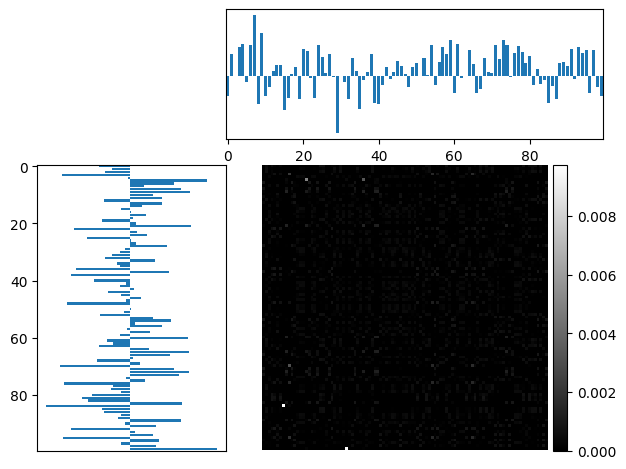

In [118]:
plot_transport_map_with_marginals(x,y,result.matrix)

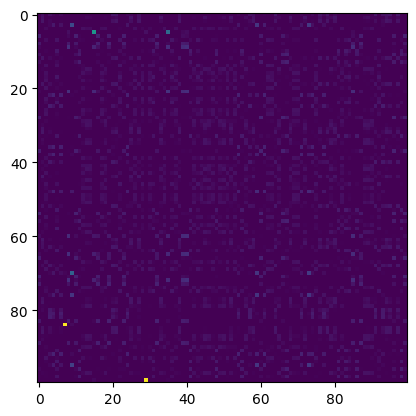

In [119]:
plt.imshow(result.matrix)

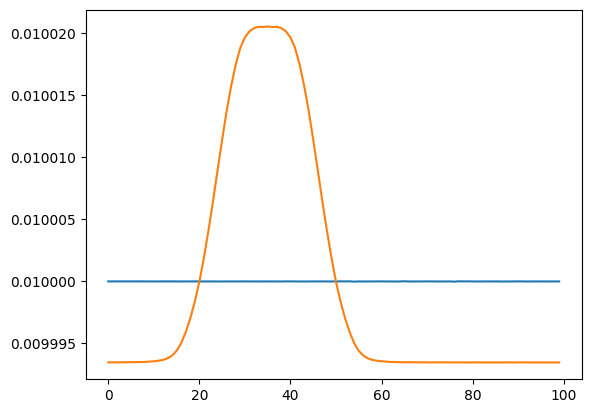

In [88]:
row_sums = np.sum(result.matrix, axis=1)
col_sums = np.sum(result.matrix, axis=0)

plt.plot(row_sums)
plt.plot(col_sums)

In [91]:
print(
    f"2-Wasserstein: Lower bound = {result.dual_cost:3f}, upper = {result.primal_cost:3f}"
)

2-Wasserstein: Lower bound = -0.000143, upper = 0.000005


In [92]:
result.transport_mass

Array(0.99999976, dtype=float32)

In [115]:
rngs = jax.random.split(jax.random.PRNGKey(0), 2)
n_x, n_y = 100, 100
x = jax.random.normal(rngs[0], (n_x, ))
y = jax.random.normal(rngs[1], (n_y, ))

In [116]:
x.shape

(100,)

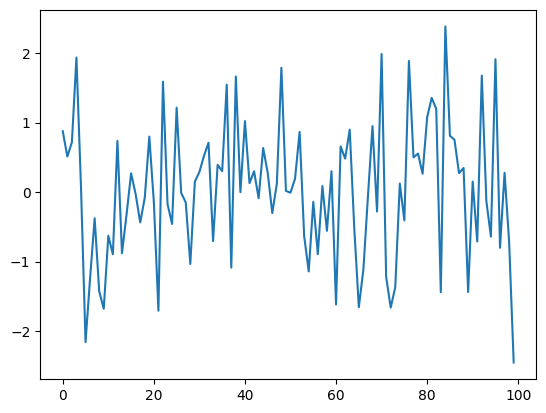

In [106]:
plt.plot(x)